In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [2]:
def convert_qual(cell):
    if cell == 'Ex':
        return 5
    elif cell == 'Gd':
        return 4
    elif cell == 'TA':
        return 3
    elif cell == 'Fa':
        return 2
    elif cell == 'Po':
        return 1
    else:
        return 0

conv_dict = {
    'Kitchen Qual' : convert_qual,
    'Fireplace Qu' : convert_qual,
    'Heating QC' : convert_qual,
    'Bsmt Qual' : convert_qual,
    'Bsmt Cond' : convert_qual,
    'Exter Qual' : convert_qual,
    'Exter Cond' : convert_qual,
    'Garage Qual' : convert_qual,
    'Garage Cond' : convert_qual,
    'Pool QC' : convert_qual,
}

In [3]:
df = pd.read_csv('datasets/train.csv', index_col = 'PID', converters = conv_dict)

In [4]:
df.drop(df[df['Gr Liv Area'] > 4000].index, inplace = True)  

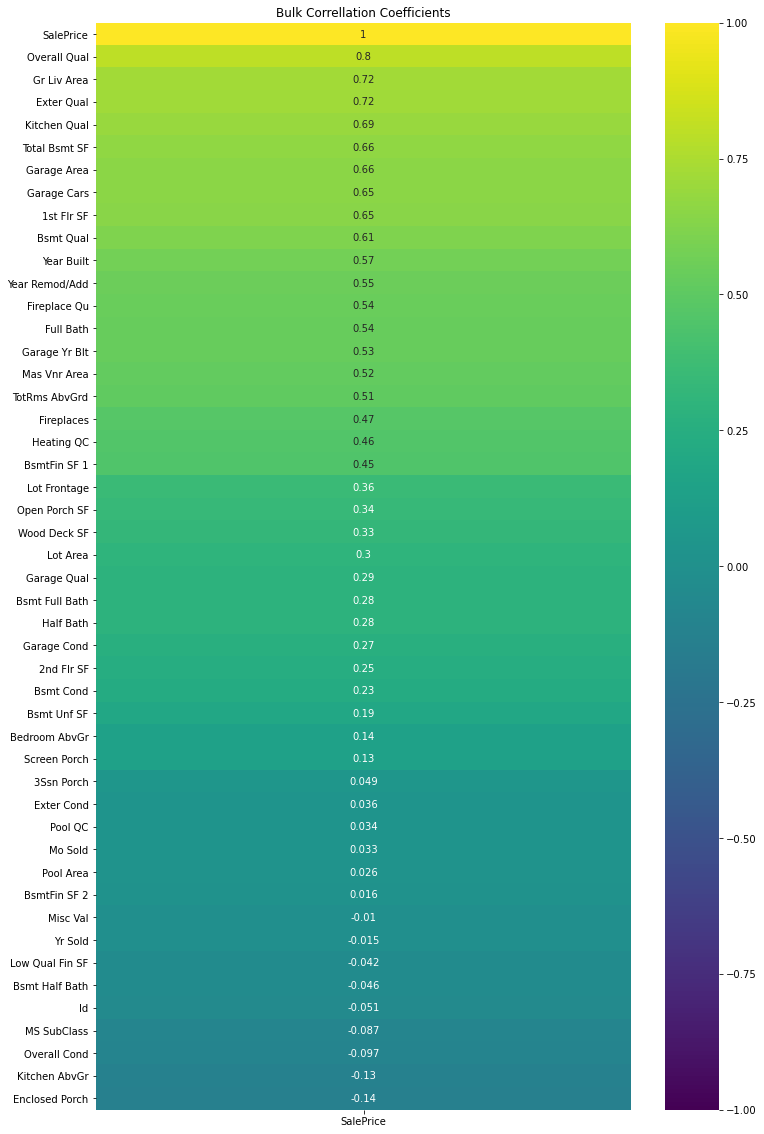

In [5]:
plt.figure(figsize = (12, 20))
sns.heatmap(df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending = False),
           vmin = -1,
           vmax = 1,
           cmap = 'viridis',
           annot = True
           );
plt.title('Bulk Correllation Coefficients')
plt.savefig('./imgs/BulkCorrelationHeatmap.png')

In [6]:
df = pd.get_dummies(df, columns = ['Neighborhood', 'Condition 1', 'Condition 2'], drop_first = True)

In [7]:
num_df = df._get_numeric_data()

In [8]:
num_df = num_df.fillna(0)

In [9]:
X = num_df.drop(columns = ['SalePrice'])
y = num_df['SalePrice']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [11]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [12]:
pca = PCA(random_state = 42)

pca.fit(X_train_sc)

Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [13]:
var_exp = pca.explained_variance_ratio_

cum_var_exp = np.cumsum(var_exp)

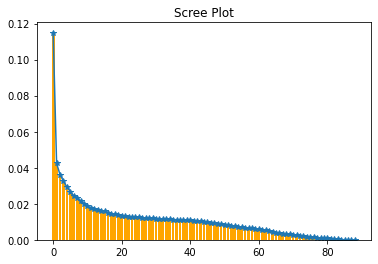

In [14]:
plt.bar(range(len(var_exp)), var_exp, color = 'orange')
plt.plot(range(len(var_exp)), var_exp, marker = '*')
plt.title('Scree Plot');

So from what we're seeing here, after the first 40 numerical features, the features are no longer having a significant affect.  So let's narrow everything down a bit.

In [15]:
pca = PCA(n_components = 40, random_state = 42)

pca.fit(X_train_sc)

Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [16]:
Z_train.shape

(1536, 40)

In [17]:
model = Sequential() # empty nn

model.add(Dense(128, 
                activation = 'relu', 
                input_shape = Z_train[0].shape,
                kernel_regularizer = l2(0.001))) 
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu', kernel_regularizer = l2(0.001))) 
model.add(Dropout(0.3))
model.add(Dense(16, activation = 'relu', kernel_regularizer = l2(0.001))) 
model.add(Dropout(0.3))
model.add(Dense(1, activation = None))
model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')
res = model.fit(Z_train, y_train,
         epochs = 250,
         batch_size = 154,
         validation_data = (Z_test, y_test),
          verbose = 0)

In [18]:
res.history['val_loss'][-1] ** 0.5

29362.248415269565

In [19]:
n_inputs = X_train_sc[-1].shape

In [20]:
model2 = Sequential() # empty nn

model2.add(Dense(128, 
                activation = 'relu', 
                input_shape = n_inputs,
                kernel_regularizer = l2(0.001))) 
model2.add(Dropout(0.3))
model2.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001)))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation = 'relu', kernel_regularizer = l2(0.001))) 
model2.add(Dropout(0.3))
model2.add(Dense(16, activation = 'relu', kernel_regularizer = l2(0.001))) 
model2.add(Dropout(0.3))
model2.add(Dense(1, activation = None))
model2.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')
res = model2.fit(X_train_sc, y_train,
         epochs = 250,
         batch_size = 154,
         validation_data = (X_test_sc, y_test),
          verbose = 0)

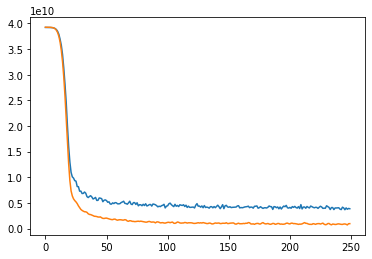

In [21]:
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])

In [22]:
res.history['val_loss'][-1] ** .5

31069.373730411753

In [23]:
preds = model2.predict(X_test_sc)

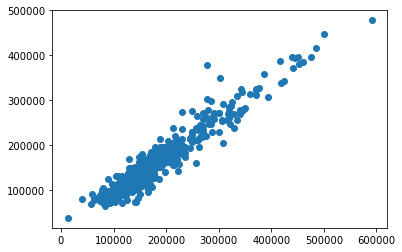

In [24]:
plt.scatter(y_test, preds)